# Walking Recalibration

This notebook is dedicated to develop examples about how to perform
a walking recalibration of a mass spectrum.

## Import PyC2MC tools

You have to import reading functions for the peaklist and the calibration list.

Then we import the `WalkingCalibration` class in order to perform the recalibration.

In [1]:
from pyc2mc.io.peaklist import read_peaklist
from pyc2mc.io.caliblist import read_caliblist

from pyc2mc.processing.recalibration import WalkingCalibration

# standard python tools
import pandas as pd
import matplotlib.pyplot as plt

## Load data for treatment

### Read mass spectrum

Read uncalibrated data.

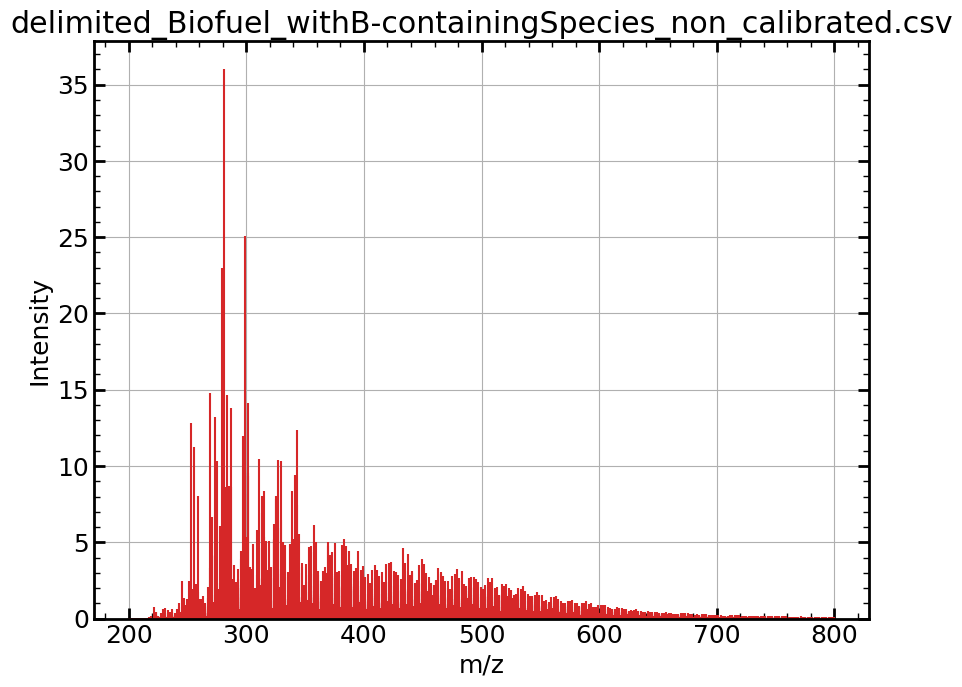

In [2]:
pl = read_peaklist("data/Biofuel_withB-containingSpecies_non_calibrated.csv")
pl = pl.delimit((200, 800))
pl.plot()

### Read calibration list

In [3]:
raw_cl = read_caliblist("data/2021July21NegESI_Sample1_TMHA_MeOH-Tol_1-1_Sum75_CalibrationList.csv", polarity=-1)
raw_cl

CalibList (101 peaks) 231.03 -> 813.35
Calibration Point: 231.03
Calibration Point: 231.07
Calibration Point: 245.05
Calibration Point: 245.08
Calibration Point: 259.06
Calibration Point: 259.10
...
Calibration Point: 785.32
Calibration Point: 789.31
Calibration Point: 799.33
Calibration Point: 803.33
Calibration Point: 813.35

## Set up calibration list

This step consists in fill the calibration list from the mass spectrum data.

* look for experimental masses
* add isotopes

In [4]:
cl = raw_cl.search_mz_exp(
    peaklist=pl,
    lambda_parameter=5,
    searching_mode="most_abundant_corrected",
)
cl

CalibList (95 peaks) 259.06 -> 799.33
Calibration Point: 259.06
Calibration Point: 259.10
Calibration Point: 273.08
Calibration Point: 273.11
Calibration Point: 287.09
Calibration Point: 287.13
...
Calibration Point: 775.30
Calibration Point: 785.32
Calibration Point: 785.32
Calibration Point: 789.31
Calibration Point: 799.33

In [5]:
cl.add_isotopes(pl, inplace=True)
cl

CalibList (109 peaks) 259.06 -> 799.33
Calibration Point: 259.06
Calibration Point: 259.10
Calibration Point: 273.08
Calibration Point: 273.11
Calibration Point: 287.09
Calibration Point: 287.13
...
Calibration Point: 775.30
Calibration Point: 785.32
Calibration Point: 785.32
Calibration Point: 789.31
Calibration Point: 799.33

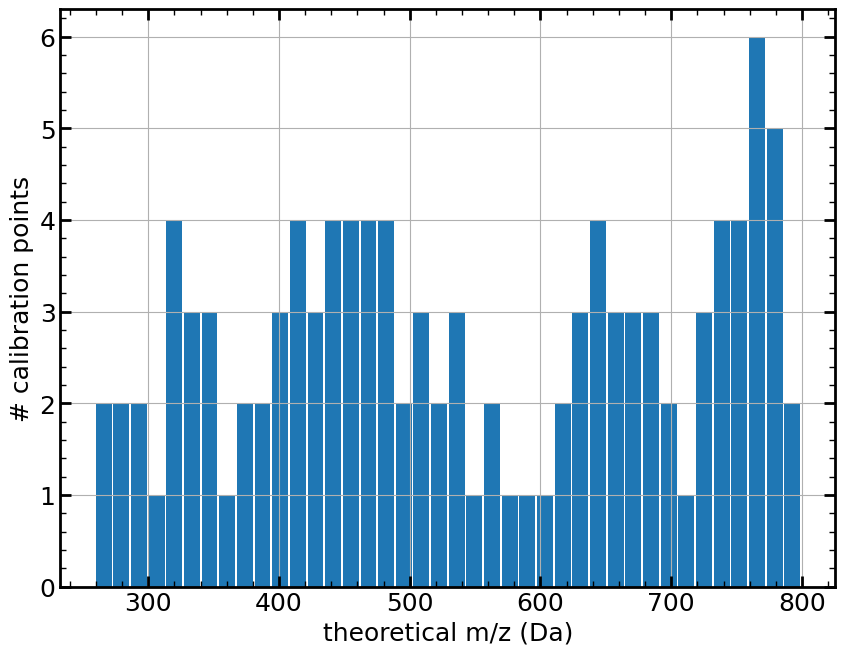

In [6]:
cl.plot.hist(bins=40)

## Perform the walking calibration

### Fix the segment size

In this first example, we perform a walking calibration, using the
Masselon equation and a segment size of 50 Da. The equation
is

$$
m/z = \frac{A}{f} + \frac{B}{f^2} + \frac{C I}{f^2}
$$
$A$, $B$ and $C$ being the parameters, $f$ the frequency and $I$ the intensity.

In [7]:
wcal1 = WalkingCalibration(
    calibration_list=cl,
    model="masselon",
    segment_size=50,
    verbose=True,
    fit_intercept=False,
)

WALKING CALIBRATION SUMMARY
---------------------------
Regression model: RecalibrationModels.MASSELON
# segments      : 10

Segment   0: 259.06 -> 313.09 (54.03)
    Calibrated: True
    # points  : 7
    Parameters: A: 3.23037e+08 B: -1.90155e+09 C: 1.36197e+07
    RMSE (ppm): 0.213872

Segment   1: 313.09 -> 367.12 (54.03)
    Calibrated: True
    # points  : 11
    Parameters: A: 3.23048e+08 B: -1.07224e+10 C: -1.52781e+08
    RMSE (ppm): 3.009474

Segment   2: 367.12 -> 421.14 (54.03)
    Calibrated: True
    # points  : 11
    Parameters: A: 3.23044e+08 B: -7.22966e+09 C: -1.79571e+09
    RMSE (ppm): 2.432986

Segment   3: 421.14 -> 475.17 (54.03)
    Calibrated: True
    # points  : 15
    Parameters: A: 3.23038e+08 B: -2.51204e+09 C: -2.80796e+05
    RMSE (ppm): 0.019546

Segment   4: 475.17 -> 529.20 (54.03)
    Calibrated: True
    # points  : 11
    Parameters: A: 3.23038e+08 B: -2.71904e+09 C: 1.51356e+06
    RMSE (ppm): 0.026536

Segment   5: 529.20 -> 583.22 (54.03)
    C

Apply the recalibration model to the initial peak list to get a recalibrated peaklist.

In [8]:
recal_pl = wcal1.recalibrate(pl)

Calibrating peaklist: delimited_Biofuel_withB-containingSpecies_non_calibrated.csv
    17347 peaks (200.23 -> 799.35) Da
981 peaks are out of the calibration list range.
mz range before calib. list: 58.83
mz range above calib. list : 0.02


#### Results

Plot the difference in ppm between raw datat and calibrated data.


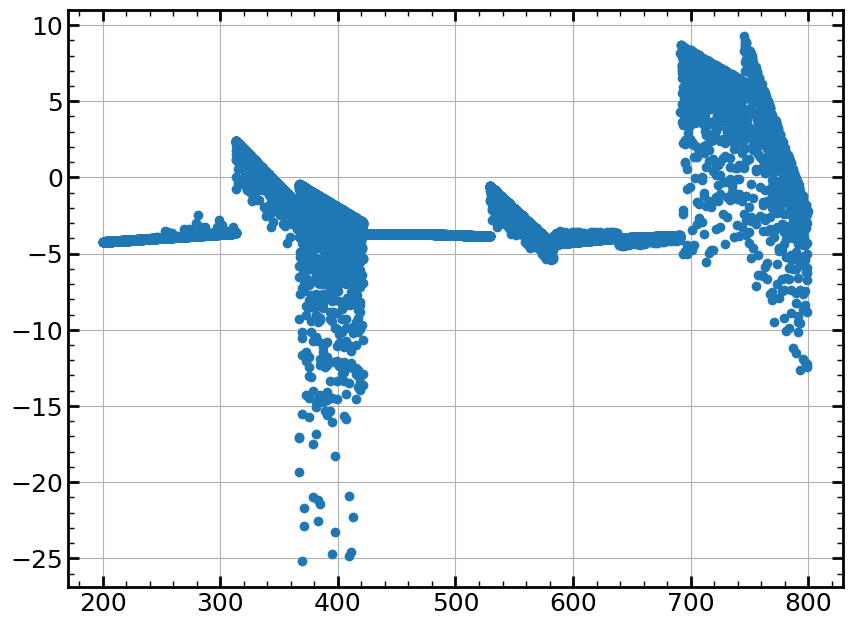

In [9]:
plt.plot(recal_pl.mz, (recal_pl.mz - pl.mz) / pl.mz * 1e6, "o")

Plot the error trends on the calibration points.

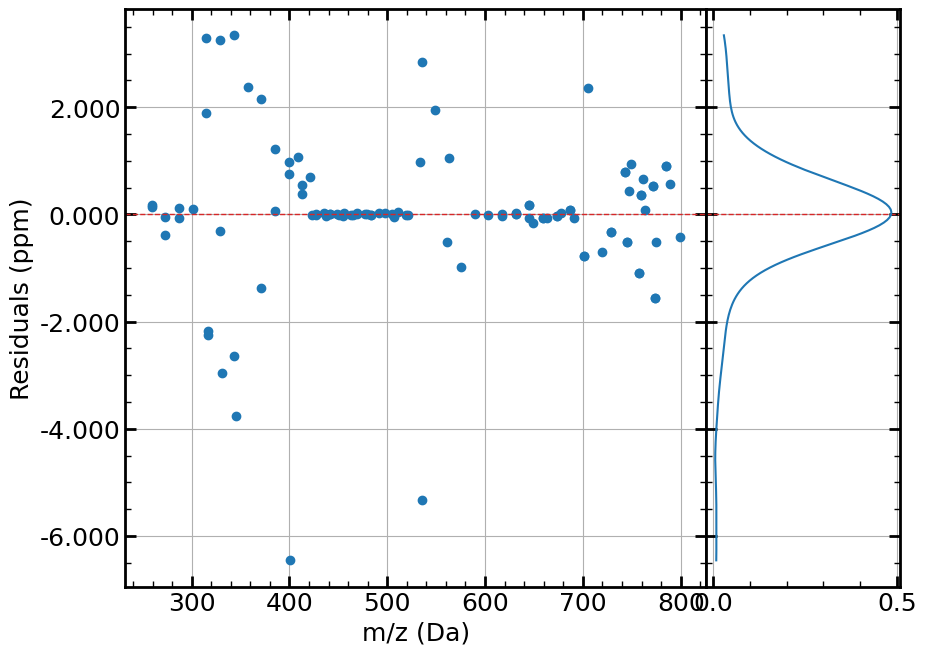

In [10]:
cl.plot.residuals(recalibration=wcal1)

You can obtain an array of the parameters

In [11]:
wcal1.opt_params

array([[ 3.23037244e+08, -1.90155004e+09,  1.36197020e+07],
       [ 3.23047755e+08, -1.07224438e+10, -1.52780805e+08],
       [ 3.23044303e+08, -7.22965732e+09, -1.79570655e+09],
       [ 3.23037847e+08, -2.51204329e+09, -2.80795880e+05],
       [ 3.23038155e+08, -2.71904204e+09,  1.51356242e+06],
       [ 3.23050992e+08, -9.89924440e+09, -2.05819423e+08],
       [ 3.23036135e+08, -1.66990933e+09,  1.30883993e+08],
       [ 3.23037012e+08, -2.10656562e+09, -1.91764863e+08],
       [ 3.23051768e+08, -6.86847406e+09, -9.43425565e+09],
       [ 3.23092635e+08, -2.39921512e+10, -1.55601203e+10]])

In [12]:
pd.DataFrame(wcal1.optimized_parameters)

A             B             C
0  3.230372e+08 -1.901550e+09  1.361970e+07
1  3.230478e+08 -1.072244e+10 -1.527808e+08
2  3.230443e+08 -7.229657e+09 -1.795707e+09
3  3.230378e+08 -2.512043e+09 -2.807959e+05
4  3.230382e+08 -2.719042e+09  1.513562e+06
5  3.230510e+08 -9.899244e+09 -2.058194e+08
6  3.230361e+08 -1.669909e+09  1.308840e+08
7  3.230370e+08 -2.106566e+09 -1.917649e+08
8  3.230518e+08 -6.868474e+09 -9.434256e+09
9  3.230926e+08 -2.399215e+10 -1.556012e+10

The segment edges are also available.

In [13]:
wcal1.segments

array([259.06093794, 313.08827558, 367.11561322, 421.14295086,
       475.1702885 , 529.19762614, 583.22496378, 637.25230142,
       691.27963905, 745.30697669, 799.33431433])

### Variable segment size

In this second segment size, the segment edges are set so that the minimum
segment width is 25 Da and the minimum number of point is 10.

In [14]:
edges = cl.get_walking_segments(min_segment_size=25, min_npts_per_segment=10)
edges

[259.06093793880297,
 317.1308238006512,
 371.22315422278297,
 423.124220123797,
 455.317138316683,
 497.32774532724795,
 561.213567213006,
 645.162010161365,
 687.2090022083149,
 745.2783699477691,
 799.334314333515]

One can visualize the corresponding segments. Adjust the two parameters to get the required segments.

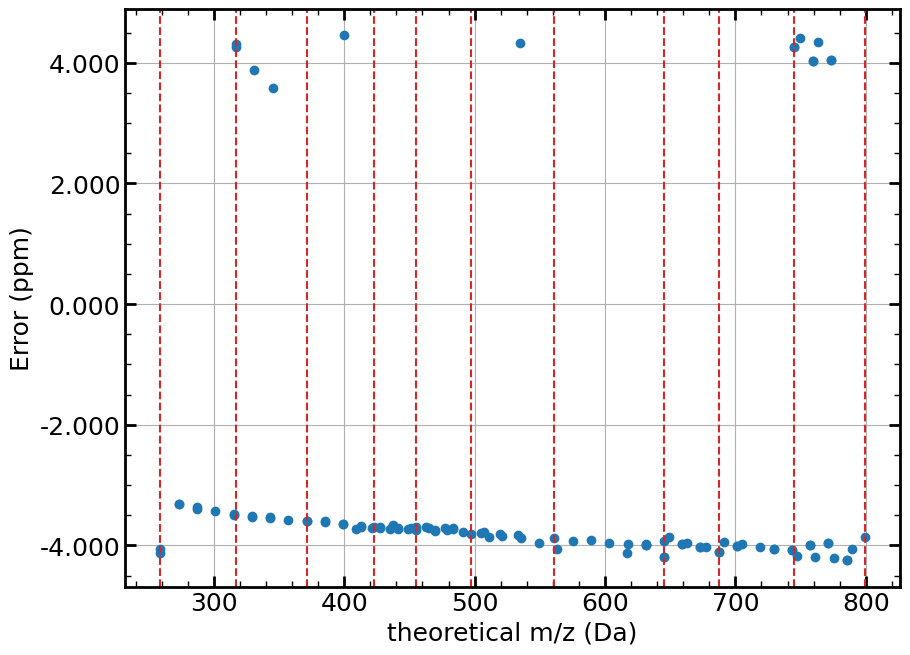

In [15]:
cl.plot.error_trend()
[plt.axvline(x, color="C3", ls="--") for x in edges];

In [16]:
wcal2 = WalkingCalibration(
    calibration_list=cl,
    model="masselon",
    segment_size=edges,  # here are the segments
    verbose=True,
    fit_intercept=False,
)

WALKING CALIBRATION SUMMARY
---------------------------
Regression model: RecalibrationModels.MASSELON
# segments      : 10

Segment   0: 259.06 -> 317.13 (58.07)
    Calibrated: True
    # points  : 10
    Parameters: A: 3.23033e+08 B: 4.36239e+09 C: -9.59482e+07
    RMSE (ppm): 1.979290

Segment   1: 317.13 -> 371.22 (54.09)
    Calibrated: True
    # points  : 10
    Parameters: A: 3.23052e+08 B: -1.51324e+10 C: -1.24520e+08
    RMSE (ppm): 2.664725

Segment   2: 371.22 -> 423.12 (51.90)
    Calibrated: True
    # points  : 10
    Parameters: A: 3.23057e+08 B: -1.68305e+10 C: -6.16316e+09
    RMSE (ppm): 2.081125

Segment   3: 423.12 -> 455.32 (32.19)
    Calibrated: True
    # points  : 10
    Parameters: A: 3.23038e+08 B: -2.54500e+09 C: 2.78803e+07
    RMSE (ppm): 0.021233

Segment   4: 455.32 -> 497.33 (42.01)
    Calibrated: True
    # points  : 10
    Parameters: A: 3.23038e+08 B: -2.65598e+09 C: -3.36019e+06
    RMSE (ppm): 0.017650

Segment   5: 497.33 -> 561.21 (63.89)
    

In [17]:
recal_pl = wcal2.recalibrate(pl)

Calibrating peaklist: delimited_Biofuel_withB-containingSpecies_non_calibrated.csv
    17347 peaks (200.23 -> 799.35) Da
981 peaks are out of the calibration list range.
mz range before calib. list: 58.83
mz range above calib. list : 0.02


#### Results

Plot the difference in ppm between raw datat and calibrated data.


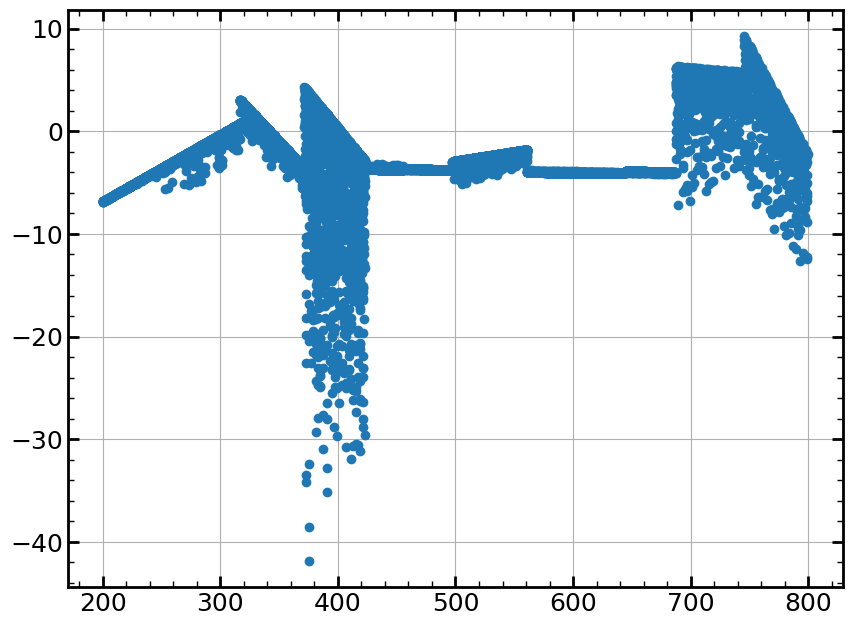

In [18]:
plt.plot(recal_pl.mz, (recal_pl.mz - pl.mz) / pl.mz * 1e6, "o")

Plot the error trends on the calibration points.

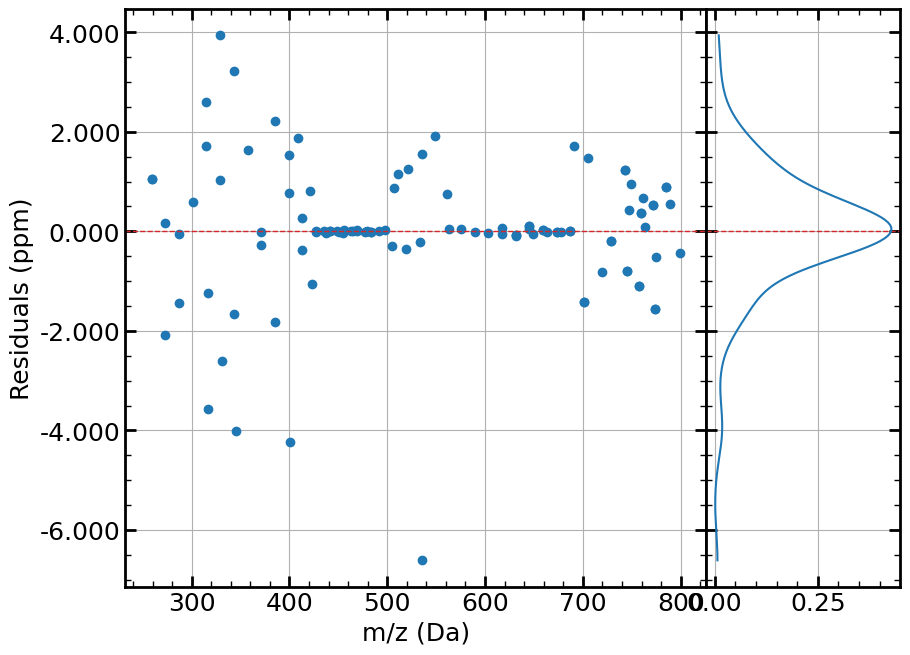

In [19]:
cl.plot.residuals(recalibration=wcal2)

You can obtain an array of the parameters

In [20]:
wcal2.opt_params

array([[ 3.23032520e+08,  4.36238698e+09, -9.59482339e+07],
       [ 3.23052384e+08, -1.51323810e+10, -1.24519991e+08],
       [ 3.23057076e+08, -1.68304936e+10, -6.16316000e+09],
       [ 3.23037886e+08, -2.54499963e+09,  2.78802794e+07],
       [ 3.23038060e+08, -2.65597655e+09, -3.36018618e+06],
       [ 3.23035061e+08, -5.34686914e+08, -1.78198416e+08],
       [ 3.23037882e+08, -2.57130826e+09,  2.75688951e+07],
       [ 3.23038485e+08, -2.83192101e+09, -7.75734660e+07],
       [ 3.23043201e+08, -3.26071232e+09, -8.39466223e+09],
       [ 3.23092635e+08, -2.39921512e+10, -1.55601203e+10]])

In [21]:
pd.DataFrame(wcal2.optimized_parameters)

A             B             C
0  3.230325e+08  4.362387e+09 -9.594823e+07
1  3.230524e+08 -1.513238e+10 -1.245200e+08
2  3.230571e+08 -1.683049e+10 -6.163160e+09
3  3.230379e+08 -2.545000e+09  2.788028e+07
4  3.230381e+08 -2.655977e+09 -3.360186e+06
5  3.230351e+08 -5.346869e+08 -1.781984e+08
6  3.230379e+08 -2.571308e+09  2.756890e+07
7  3.230385e+08 -2.831921e+09 -7.757347e+07
8  3.230432e+08 -3.260712e+09 -8.394662e+09
9  3.230926e+08 -2.399215e+10 -1.556012e+10

You can now use the `recal_pl` peaklist to perform attribution.